# Desafío - Machine Learning 

In [92]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from warnings import WarningMessage

WarningMessage = False

plt.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en el sistema.
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [2]:
data_web = pd.read_csv("data/usuarios_win_mac_lin_train.csv")
data_web.describe()

data_validation = pd.read_csv("data/data_validation_without_class.csv")

## Analisis de los datos

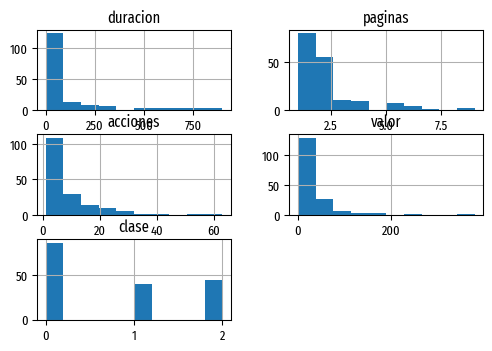

In [40]:
hist = data_web.hist(bins=10)

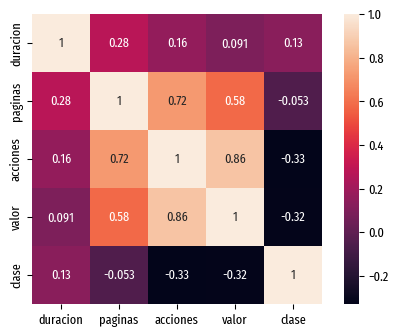

In [24]:
corr = data_web.corr()
sns.heatmap(corr, annot = True, square = True);

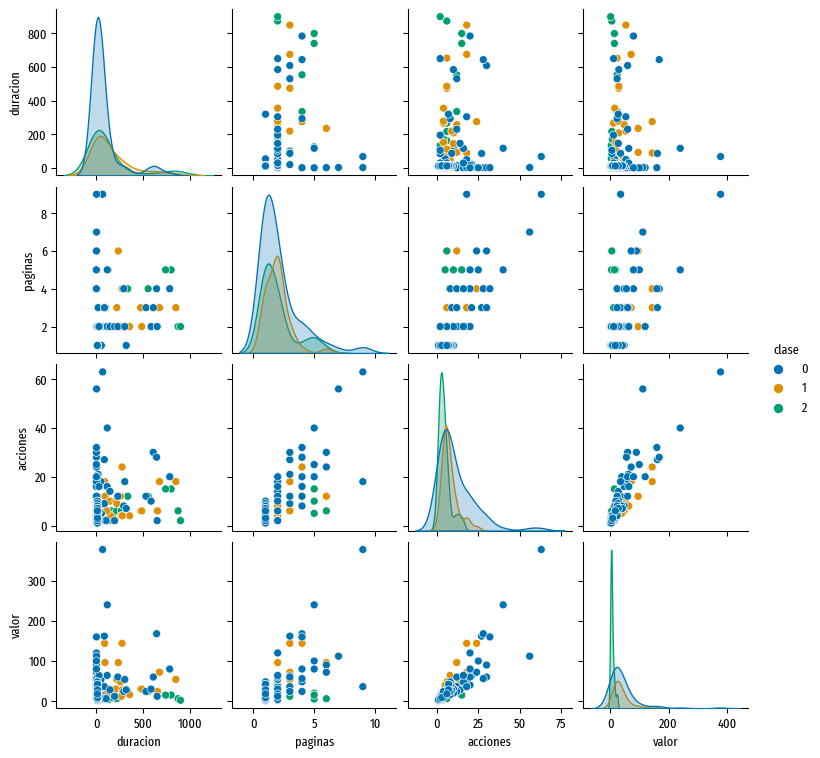

In [25]:
sns.pairplot(data_web, hue="clase", height = 2, palette = 'colorblind')

## Modelo

Clasificador DecisionTree

* Pendiente: Aplicar PCA antes 

In [47]:
X=data_web[['duracion', 'paginas', 'acciones', 'valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) 

In [55]:
# Con menos componentes
X=data_web[['acciones','valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) 

In [56]:
# Árbol de desición
modelo_tree=DecisionTreeClassifier(max_depth = 3, random_state = 1, )
# fit
modelo_tree.fit(X_train,y_train)

y_pred=modelo_tree.predict(X_test)

In [57]:
modelo_tree.feature_importances_

array([0.19659777, 0.80340223])

In [58]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7205882352941176


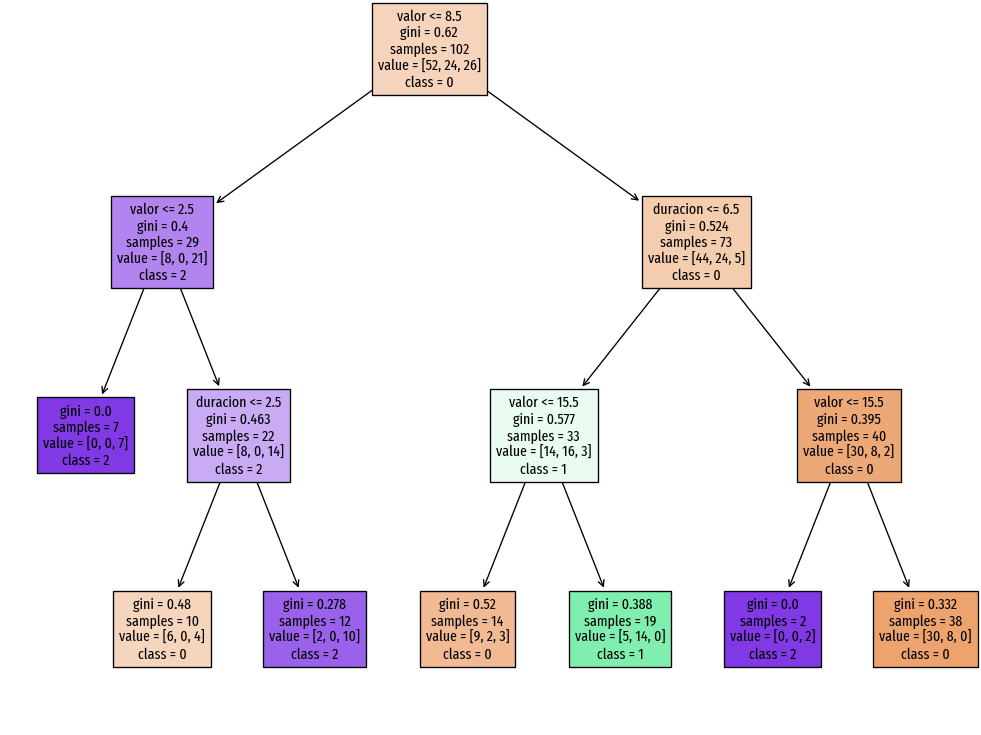

In [59]:
#fn = ['duracion', 'paginas', 'acciones', 'valor']
fn = ['duracion', 'valor']
cn = ["0", "1", "2"]

plt.figure(figsize = (10,8))
plot_tree(modelo_tree, feature_names = fn, class_names = cn, filled = True)
plt.tight_layout(h_pad=0.5, w_pad=0.5)

# Si el gini tiende a cero, el error tiende a cero

In [60]:
predicciones = modelo_tree.predict(X = X_test)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.68      0.82      0.75        34
           1       0.62      0.50      0.55        16
           2       0.93      0.72      0.81        18

    accuracy                           0.72        68
   macro avg       0.74      0.68      0.70        68
weighted avg       0.73      0.72      0.72        68



# Modelo 2

Random Forest

In [107]:
modelo_rf =  RandomForestClassifier(
            n_estimators = 100,
            n_jobs       = -1,
            max_depth= 6,
            random_state = 1
         )
      
modelo_rf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=1)

In [112]:
# Accuracy
# ==============================================================================
y_pred = modelo_rf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7352941176470589


In [113]:
predicciones = modelo_rf.predict(X = X_test.values)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        34
           1       0.56      0.56      0.56        16
           2       0.94      0.83      0.88        18

    accuracy                           0.74        68
   macro avg       0.74      0.72      0.73        68
weighted avg       0.74      0.74      0.74        68



In [115]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100,150],
                 'max_features': [1,2],
                 'max_depth'   : [None,3, 6, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train.values, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion'

,oob_accuracy,criterion,max_depth,max_features,n_estimators
31,0.764706,entropy,10.0,2,150
30,0.764706,entropy,10.0,2,100
27,0.764706,entropy,6.0,2,150
19,0.764706,entropy,NaN,2,150
